# Likelihood Analysis with fermipy

The python likelihood tools are a very powerful set of analysis tools that expand upon the command line tools provided with the Fermi Science Tools package. Not only can you perform all of the same likelihood analysis with the python tools that you can with the standard command line tools but you can directly access all of the model parameters. You can more easily script a standard analysis. There are also a few things built into the python tools that are not available from the command line like the calculation of upper limits.

There are many user contributed packages built upon the python backbone of the Science Tools and this thread will highlight the use of the [fermipy](http://fermipy.readthedocs.org) package.

This tutorial was built strongly based on tutorials distributed by the fermipy team and available at [this page](https://github.com/fermiPy/fermipy-extra).

We are going to study the blazar TXS 0506+056. If this name sounds familiar to you, its because the neutrino IceCube-170922A was detected comming from a direction consistent with the location of TXS 0506+056, observed to be in a flaring state. The results were published by [IceCube Collaboration et al. 2018](https://arxiv.org/abs/1807.08816). In our work, among other things, we are going to creat a Light Curve with Fermi-LAT data, similar to the one published in their Figure 3.

## Get the Data

For this thread the original data were extracted from the [LAT data server](http://fermi.gsfc.nasa.gov/cgi-bin/ssc/LAT/LATDataQuery.cgi) with the following selections:

* Search Center (RA,Dec) = (77.3582,5.69315)
* Radius = 15 degrees
* Start Time (MET) = 494380804 seconds (2016-09-01 00:00:00)
* Stop Time (MET) = 557452805 seconds (2018-09-01 00:00:00)
* Minimum Energy = 100 MeV
* Maximum Energy = 300000 MeV

You don't need to download anything now. The data is already available with the Docker image you already have. But you'll then need to make a file list with the names of your input event files. You can either just make one with a text editor or do the following from the command line.

In [3]:
!ls ./data/*PH* > Blazar.lst

## Make a config file

fermipy bases its analysis on a configuration file (in [yaml](http://yaml.org) format).  We're just going to use a really simple config file for a standard analysis.  There are many many more options which you can use or you can modify these options after the fact within the analysis chain.

You don't have to create this file. It is already in the Docker image.

But, if you are going to use this tutorial as a template to another analysis, make a config file named 'config.yaml' like the following (we are using the parameters for our analysis here as an example). For more details on the config file see [this page](http://fermipy.readthedocs.org/en/latest/config.html).  You will probably need to customize this a bit since your files might not be in the same place or named the same.  The galactic and isotropic diffuse will need to be located on your system (they are included in the science tools or can be downloaded from the FSSC).  In the following example we set the path to these files with the environment variable FERMI_DIFFUSE_DIR.  If FERMI_DIFFUSE_DIR is not defined fermipy will look for the location of these files within the FSSC STs distribution. 

```
data:
  evfile : Blazar.lst
  scfile : L190726155320A894EC7048_SC00.fits

binning:
  roiwidth   : 10.0
  binsz      : 0.1
  binsperdec : 8

selection :
  emin : 100
  emax : 300000
  zmax    : 90
  evclass : 128
  evtype  : 3
  target : '3FGL J0509.4+0541'

gtlike:
  edisp : True
  irfs : 'P8R2_SOURCE_V6'
  edisp_disable : ['isodiff','galdiff']

model:
  src_roiwidth : 15.0
  galdiff  : '/workdir/notebooks/data/gll_iem_v06.fits'
  isodiff  : '/workdir/notebooks/data/iso_P8R2_SOURCE_V6_v06.txt'
  catalogs : '/workdir/notebooks/data/gll_psc_v16.xml'
```

OBS: the blazar TXS 0506+056 is part of the Fermi's Catalogues. The newest version is the [Fermi Large Area Telescope Fourth Source Catalog](https://arxiv.org/abs/1902.10045) (4FGL). But, in this tutorial, we will use the previous version (3FGL), as in IceCube Collaboration et al. 2018. In 3FGL the source is called 3FGL J0509.4+0541. So, for now on, we are going to refer to this source as 3FGL J0509.4+0541 during the analysis.

## Start the analysis

Next, you create an analysis script and run the setup steps which include running the selections and generating exposure maps etc.  This will take a bit.

This is where the magic happens.  fermipy will load the point source model, create your xml file for you, decide on all the appropriate cuts and binnings and just go.  All of this is configurable from python or from the config file.  And, if you need to rerun things, it's smart enough to not overwrite files if it doesn't need to.

### Load up some useful modules

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

### Import the GTAnalysis module from fermipy

You start by importing the module and then creating an instance of the analysis object from our config file.  When instantiating the analysis object we can override any options defined in the configuration file by passing keyword arguments to the object constructor.  Here we explicitly set the verbosity parameter to 3 (INFO) which supresses DEBUG output.  When we create the object, it spits out a bunch of information about all of the parameters that were used.  You can see there are many more options than the ones we chose.

In [44]:
from fermipy.gtanalysis import GTAnalysis
gta = GTAnalysis('blazar/config.yaml',logging={'verbosity': 3})
matplotlib.interactive(True)

2019-07-31 19:44:31 INFO    GTAnalysis.__init__(): 
--------------------------------------------------------------------------------
fermipy version 0.14.1 
ScienceTools version ScienceTools-11-05-02


### The setup routine

This gets everything ready for the likelihood analysis including instantiating the pylikelihood object.  Note that fermipy will skip generating any ancillary files that already exist in the working directory.  In the sample tarball these files have already been produced in order to speed up this stage of the analysis.  If you want to see the behavior of fermipy when running from an empty working directory you can delete one or more of these files before running *setup*.

In [45]:
gta.setup()

2019-07-31 19:44:54 INFO    GTAnalysis.setup(): Running setup.
2019-07-31 19:44:54 INFO    GTBinnedAnalysis.setup(): Running setup for component 00
2019-07-31 19:44:54 INFO    GTBinnedAnalysis.run_gtapp(): Running gtselect.
2019-07-31 19:44:54 INFO    GTBinnedAnalysis.run_gtapp(): time -p gtselect infile=/workdir/notebooks/blazar/evfile_00.txt outfile=/workdir/notebooks/blazar/ft1_00.fits ra=77.3639 dec=5.699 rad=7.57106781187 tmin="INDEF" tmax="INDEF" emin=100.0 emax=300000.0 zmin=0.0 zmax=90.0 evclass=128 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=3 clobber=yes debug=no gui=no mode="ql"
2019-07-31 19:44:57 INFO    GTBinnedAnalysis.run_gtapp(): This is gtselect version ScienceTools-11-05-02
2019-07-31 19:44:57 INFO    GTBinnedAnalysis.run_gtapp(): Applying filter string: ((EVENT_CLASS&o200) != o0) && angsep(RA,DEC,77.3639,5.699) < 7.571067812 && ((EVENT_TYPE&o3) != o0) && 100 < ENERGY && ENERGY <= 300000 && 0 < ZENITH_ANGLE && ZENITH_ANGLE <= 90 && gtifilt

2019-07-31 20:35:08 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 3FGL J0442.6-0017....................!
2019-07-31 20:35:08 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 3FGL J0449.0+1121....................!
2019-07-31 20:35:08 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 3FGL J0457.0+0643....................!
2019-07-31 20:35:08 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 3FGL J0502.5+0612....................!
2019-07-31 20:35:08 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 3FGL J0505.3+0459....................!
2019-07-31 20:35:08 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 3FGL J0505.5+0416....................!
2019-07-31 20:35:08 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 3FGL J0506.9+0321....................!
2019-07-31 20:35:08 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 3FGL J0509.3+1012....................!
2019-07-31 20:35:08 INFO

You can see in the outputs above that several steps of the setup were skipped. Also, we are "Using external LT cube". It happens because we already provided the Docker image with preprocessed files so we could run the analysis during the time available for our activity.

Before proceeding with the analysis we'll have a quick look at the files that are produced by the setup function.

In [47]:
ls blazar/*fits

blazar/bexpmap_00.fits      blazar/ccube.fits      blazar/srcmap_00.fits
blazar/bexpmap_roi_00.fits  blazar/ft1_00.fits
blazar/ccube_00.fits        blazar/ltcube_00.fits


Here is a brief explanation of the contents of each file and its role in the analysis:

* **ft1_00.fits**: Event list.  This is generated by running gtselect and gtmktime on our input file list.
* **bexpmap_00.fits**: All-sky binned exposure map.  This map is interpolated to create an exposure model when generating the srcmap file.
* **bexpmap_roi_00.fits**: Binned exposure map for the ROI.  This file is only provided for visualization purposes in order to have an exposure map with the same binning as the data and model maps.
* **ccube_00.fits**: Counts cube for the ROI.
* **ltcube_00.fits**: Livetime cube.  This contains a map of the livetime for this observation over the whole sky as a function of incidence angle.
* **srcmap_00.fits**: Source map cube.  This file contains maps for each of the components in the ROI after convolution with exposure and the PSF.  Note that energy dispersion is applied at run-time.

Note that all of the files have a numerical suffix '00'.  This is the analysis component index.  In a multi-component analysis there would be instances of all of the above files for each analysis component.  The files with no component index are co-added maps that are provided for visualization purposes.

To see example of one of these files we can open and plot the counts cube file.  This is a 3D cube that contains the distribution of events as a function of energy and two spatial coordinates.  In the example below we sum over the energy dimension of the cube to make a 2-D sky image.

Filename: blazar/ccube.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      25   (100, 100, 28)   float64   


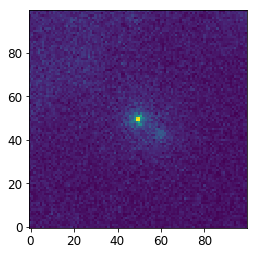

In [49]:
import astropy.io.fits as pyfits

h = pyfits.open('blazar/ccube.fits')
h.info()
counts = h[0].data
counts.shape
plt.figure()
plt.imshow(np.sum(counts,axis=0),interpolation='nearest',origin='lower')

We can now inspect the state of the ROI prior with the print_roi() method.

In [50]:
gta.print_roi()

2019-07-31 20:36:59 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
3FGL J0509.4+0541   PointSource    PowerLaw          0.000       nan      2536.2
3FGL J0505.3+0459   PointSource    LogParabola       1.235       nan      1889.0
3FGL J0505.5+0416   PointSource    PowerLaw          1.729       nan       162.2
3FGL J0502.5+0612   PointSource    PowerLaw          1.803       nan       590.0
3FGL J0506.9+0321   PointSource    PowerLaw2         2.420       nan        60.4
3FGL J0457.0+0643   PointSource    PowerLaw          3.243       nan       339.8
3FGL J0517.5+0902   PointSource    PowerLaw          3.898       nan       292.3
3FGL J0519.5+0852   PointSource    LogParabola       4.034       nan       624.5
3FGL J0509.3+1012   PointSource    PowerLaw          4.502       nan       562.9
3FGL J0516.6+1012   PointSource    PowerLaw2         4.8

Additional details about an individual source can be retrieved by printing the corresponding source object.  Here we use the bracket operator to return the properties of 3FGL J0509.4+0541. 

In [51]:
print(gta.roi['3FGL J0509.4+0541'])

Name           : 3FGL J0509.4+0541
Associations   : ['3FGL J0509.4+0541']
RA/DEC         :     77.364/     5.699
GLON/GLAT      :    195.403/   -19.628
TS             : nan
Npred          : 2536.22
Flux           : 7.146e-08 +/-      nan
EnergyFlux     : 5.132e-05 +/-      nan
SpatialModel   : PointSource
SpectrumType   : PowerLaw
Spectral Parameters
Prefactor      :  3.682e-12 +/-  1.182e-13
Index          :     -2.037 +/-     0.0254
Scale          :       1352 +/-        nan


## Do the likelihood fitting

Now that all of the ancillary files have been generated, we can move on to the actual fitting.  The first thing you should do is free some of the sources since all of the sources are initially fixed.  We'll just free those sources in the center region.

In [52]:
gta.free_sources(False)

# Free Normalization of all Sources within 3 deg of ROI center
gta.free_sources(distance=3.0,pars='norm')

# Free all parameters of isotropic and galactic diffuse components
gta.free_source('galdiff')
gta.free_source('isodiff')

2019-07-31 20:39:33 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0509.4+0541     : ['Prefactor', 'Index']
2019-07-31 20:39:33 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0505.3+0459     : ['norm', 'alpha', 'beta']
2019-07-31 20:39:33 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0505.5+0416     : ['Prefactor', 'Index']
2019-07-31 20:39:33 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0502.5+0612     : ['Prefactor', 'Index']
2019-07-31 20:39:33 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0506.9+0321     : ['Integral', 'Index']
2019-07-31 20:39:33 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0457.0+0643     : ['Prefactor', 'Index']
2019-07-31 20:39:33 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0517.5+0902     : ['Prefactor', 'Index']
2019-07-31 20:39:33 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0519.5+0852     : ['norm', 'alpha', 'beta']
2019-07-31 

In this simple anlaysis we are leaving the spectral shapes of sources fixed but we're going to free the spectral shape of the source we care about.  

In [53]:
gta.free_source('3FGL J0509.4+0541')

2019-07-31 20:39:39 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J0509.4+0541     : ['Index']


Now, actually do the fit.  The software does its best to get the fit to converge by running the fit several times.

In [54]:
fit_results = gta.fit()

2019-07-31 20:40:12 INFO    GTAnalysis.fit(): Starting fit.
/opt/conda/lib/python2.7/site-packages/scipy/interpolate/fitpack2.py:224: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/opt/conda/lib/python2.7/site-packages/fermipy/utils.py:739: RuntimeWarning: invalid value encountered in less
  if np.any(fn_val[:imax] < -deltalnl):
2019-07-31 20:40:20 INFO    GTAnalysis.fit(): Fit returned successfully. Quality:   3 Status:   0
2019-07-31 20:40:20 INFO    GTAnalysis.fit(): LogLike:   -91275.671 DeltaLogLike:      753.001 


The dictionary returned by the fit method returns a variety of diagnostic information about the fit including the fit quality, the relative improvement in the likelihood, and the correlations among the fit parameters.  We can inspect the results of the fit by printing the source object for 3FGL J0509.4+0541.

In [55]:
print('Fit Quality: ',fit_results['fit_quality'])
print(gta.roi['3FGL J0509.4+0541'])

('Fit Quality: ', 3)
Name           : 3FGL J0509.4+0541
Associations   : ['3FGL J0509.4+0541']
RA/DEC         :     77.364/     5.699
GLON/GLAT      :    195.403/   -19.628
TS             : 6606.59
Npred          : 6640.10
Flux           : 1.896e-07 +/- 6.08e-09
EnergyFlux     : 0.0001254 +/- 4.18e-06
SpatialModel   : PointSource
SpectrumType   : PowerLaw
Spectral Parameters
Prefactor      :  9.301e-12 +/-  2.181e-13
Index          :     -2.067 +/-    0.01743
Scale          :       1352 +/-        nan


You can then save the state of the roi to an output file for reference later.  The write_roi function does this.  The first argument is a string that will be prepended to the names of the output files generated by this method.

In [56]:
gta.write_roi('fit0',make_plots=True)

2019-07-31 20:40:57 INFO    GTBinnedAnalysis.write_xml(): Writing /workdir/notebooks/blazar/fit0_00.xml...
2019-07-31 20:40:57 INFO    GTAnalysis.write_fits(): Writing /workdir/notebooks/blazar/fit0.fits...
2019-07-31 20:40:58 INFO    GTAnalysis.write_roi(): Writing /workdir/notebooks/blazar/fit0.npy...


There are a lot of diagnostic plots also saved at the same time.  

In [58]:
ls -l blazar/*.png

-rw-r--r-- 1 root root 82818 Jul 31 20:41 blazar/fit0_counts_map_2.000_5.477.png
-rw-r--r-- 1 root root 26794 Jul 31 20:41 blazar/fit0_counts_map_xproj_2.000_5.477.png
-rw-r--r-- 1 root root 26021 Jul 31 20:41 blazar/fit0_counts_map_yproj_2.000_5.477.png
-rw-r--r-- 1 root root 61405 Jul 31 20:41 blazar/fit0_counts_spectrum.png
-rw-r--r-- 1 root root 65959 Jul 31 20:41 blazar/fit0_model_map_2.000_5.477.png


In [59]:
from IPython.display import Image, display
from glob import glob

In [65]:
pngs = glob('blazar/*.png')

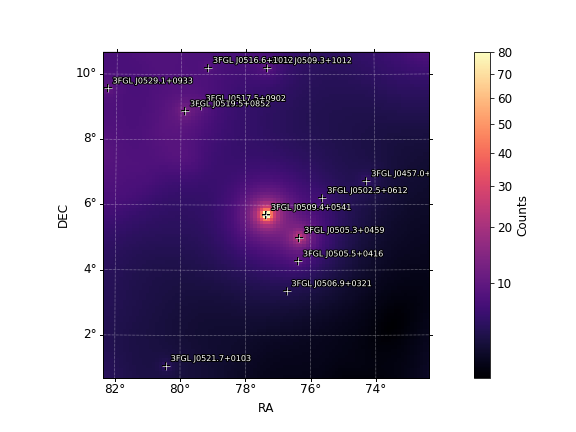

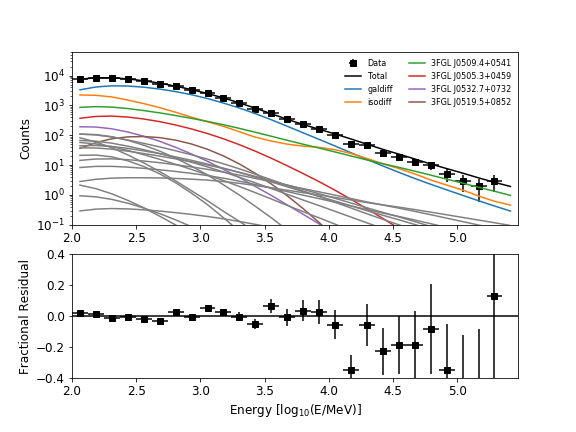

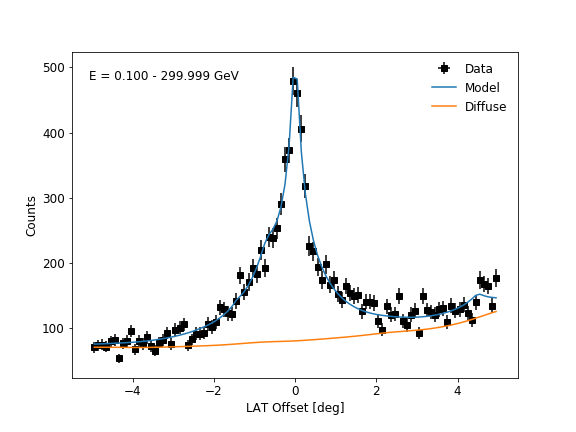

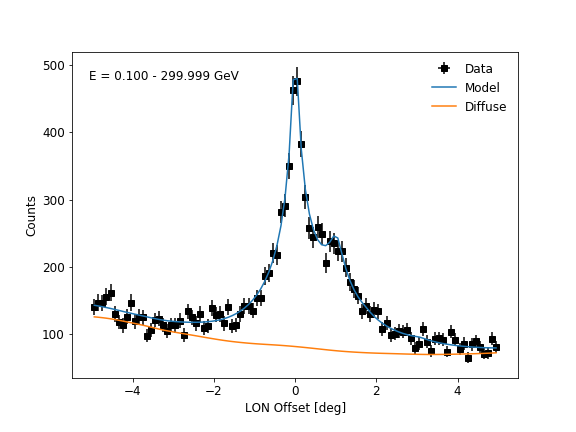

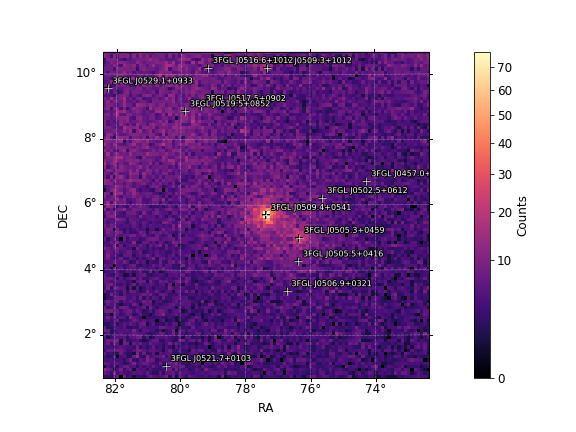

In [66]:
for png in pngs:
    my_image = Image(png)
    display(my_image)

### Reading in the results

Since the results are saved, you can load them back up at any point (you can also get to these within python).  Here we retrieve the analysis results from the output numpy file. 

In [68]:
c = np.load('blazar/fit0.npy').flat[0]

The `sources` dictionary has an entry for each source in the model:

In [69]:
sorted(c['sources'].keys())

['3FGL J0442.6-0017',
 '3FGL J0449.0+1121',
 '3FGL J0457.0+0643',
 '3FGL J0502.5+0612',
 '3FGL J0505.3+0459',
 '3FGL J0505.5+0416',
 '3FGL J0506.9+0321',
 '3FGL J0509.3+1012',
 '3FGL J0509.4+0541',
 '3FGL J0515.5-0123',
 '3FGL J0516.6+1012',
 '3FGL J0517.5+0902',
 '3FGL J0519.5+0852',
 '3FGL J0521.7+0103',
 '3FGL J0529.1+0933',
 '3FGL J0532.7+0732',
 '3FGL J0537.0+0957',
 '3FGL J0540.0+1208',
 'galdiff',
 'isodiff']

Let's take a look at the flux, spectral parameters, and TS.

In [70]:
c['sources']['3FGL J0509.4+0541']['flux']

1.8964551444408544e-07

In [71]:
print(c['sources']['3FGL J0509.4+0541']['param_names'][:4])
print(c['sources']['3FGL J0509.4+0541']['param_values'][:4])

['Prefactor' 'Index' 'Scale' '']
[  9.30063961e-12  -2.06680236e+00   1.35173488e+03              nan]


In [72]:
c['sources']['3FGL J0509.4+0541']['ts']

6606.591948416695

### SED

The SED is in there as well.  We can plot it.

In [73]:
E = np.array(c['sources']['3FGL J0509.4+0541']['model_flux']['energies'])
dnde = np.array(c['sources']['3FGL J0509.4+0541']['model_flux']['dnde'])
dnde_hi = np.array(c['sources']['3FGL J0509.4+0541']['model_flux']['dnde_hi'])
dnde_lo = np.array(c['sources']['3FGL J0509.4+0541']['model_flux']['dnde_lo'])

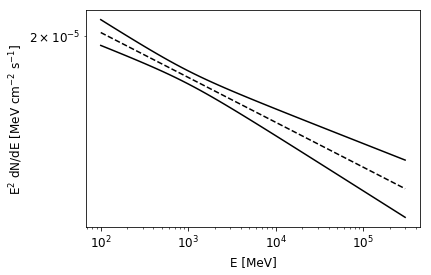

In [74]:
plt.loglog(E, (E**2)*dnde, 'k--')
plt.loglog(E, (E**2)*dnde_hi, 'k')
plt.loglog(E, (E**2)*dnde_lo, 'k')
plt.xlabel('E [MeV]')
plt.ylabel(r'E$^2$ dN/dE [MeV cm$^{-2}$ s$^{-1}$]')
plt.show()

If you want SED points, there's a function for that.  There are lots of options for this which you can set in the config file or from keyword arguments of the function itself.

In [75]:
sed = gta.sed('3FGL J0509.4+0541')

2019-07-31 20:43:51 INFO    GTAnalysis.sed(): Computing SED for 3FGL J0509.4+0541
2019-07-31 20:43:53 INFO    GTAnalysis._make_sed(): Fitting SED
2019-07-31 20:43:53 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0509.4+0541     : ['Index']
2019-07-31 20:43:53 INFO    GTAnalysis.free_source(): Fixing parameters for galdiff               : ['Index']
2019-07-31 20:44:01 INFO    GTAnalysis.sed(): Finished SED


You can save the state to the yaml file or you can just access it directly.  This is also the way to get at the dictionary for any individual source.

In [76]:
src = gta.roi['3FGL J0509.4+0541']

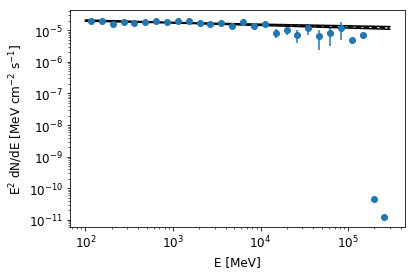

In [78]:
plt.loglog(E, (E**2)*dnde, 'k--')
plt.loglog(E, (E**2)*dnde_hi, 'k')
plt.loglog(E, (E**2)*dnde_lo, 'k')
plt.errorbar(np.array(sed['e_ctr']),
             sed['e2dnde'], 
             yerr=sed['e2dnde_err'], fmt ='o')
plt.xlabel('E [MeV]')
plt.ylabel(r'E$^{2}$ dN/dE [MeV cm$^{-2}$ s$^{-1}$]')
plt.show()

Looks like those last five points should be upper limits.  Let's plot those instead.

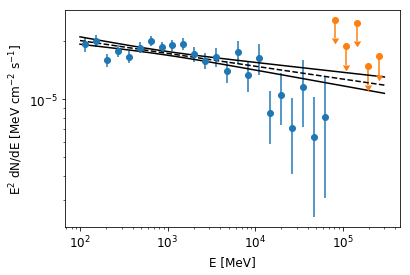

In [81]:
plt.loglog(E, (E**2)*dnde, 'k--')
plt.loglog(E, (E**2)*dnde_hi, 'k')
plt.loglog(E, (E**2)*dnde_lo, 'k')
plt.errorbar(sed['e_ctr'][:-5],
             sed['e2dnde'][:-5], 
             yerr=sed['e2dnde_err'][:-5], fmt ='o')
plt.errorbar(np.array(sed['e_ctr'][-5:]),
         sed['e2dnde_ul95'][-5:], yerr=0.2*sed['e2dnde_ul95'][-5:], 
             fmt='o', uplims=True)
plt.xlabel('E [MeV]')
plt.ylabel('E$^{2}$ dN/dE [MeV cm$^{-2}$ s$^{-1}$]')
plt.show()

### Light curve

The creation of light curves is very time consuming. It basically divides the period of the analysis in smaller bins and then perform a fit in for each bin. It allows us to investigate the variability of the source through time.

Here, to speed things up, we are going to create a very simple light curve for our source, focused only on the few months before and after the neutrino detection. It was detected in September 22nd 2017 at 20:54:30.4, which corresponds to 527806475.400 "Fermi seconds" (starting in 2001.0 UTC). To check the conversion between dates and "Fermi seconds", you can use this [website](https://heasarc.gsfc.nasa.gov/cgi-bin/Tools/xTime/xTime.pl).

On the following steps, we are going to create the time bins will be used in the light curve creation. It would be impossible to create a light curve for the whole period of analysis (from 2016-09-01 to 2018-09-01) during the time available for this tutorial.

The creation of the light curve will take up to 1 hour, depending on your computer capacity and number of cores available in your machine.

In [96]:
binsize = 30 #time bin in days

tneutrino = 527806475.400 #Fermi seconds of September 22nd 2017
binsbefore = 13 #number of time bins before the neutrino detection
binsafter = 13 #number of time bins after the neutrino detection

tminLC = tneutrino-(binsbefore*binsize*24*60*60) #start of the first time bin

binsLC = np.array(range(0,binsbefore+binsafter+1))
binsLC = binsLC*(binsize*24*60*60)+tminLC
binsLC=list(binsLC)

binsLC

[494110475.39999998,
 496702475.39999998,
 499294475.39999998,
 501886475.39999998,
 504478475.39999998,
 507070475.39999998,
 509662475.39999998,
 512254475.39999998,
 514846475.39999998,
 517438475.39999998,
 520030475.39999998,
 522622475.39999998,
 525214475.39999998,
 527806475.39999998,
 530398475.39999998,
 532990475.39999998,
 535582475.39999998,
 538174475.39999998,
 540766475.39999998,
 543358475.39999998,
 545950475.39999998,
 548542475.39999998,
 551134475.39999998,
 553726475.39999998,
 556318475.39999998,
 558910475.39999998,
 561502475.39999998]

In [97]:
lc = gta.lightcurve('3FGL J0509.4+0541', free_params=['Prefactor'], time_bins=binsLC)

2019-08-01 19:57:59 INFO    GTAnalysis.lightcurve(): Computing Lightcurve for 3FGL J0509.4+0541
2019-08-01 19:57:59 INFO    GTAnalysis._make_lc(): Fitting time range 494110475 496702475
2019-08-01 19:58:23 INFO    GTBinnedAnalysis._create_ltcube(): Generating local LT cube.
2019-08-01 20:01:16 INFO    GTBinnedAnalysis.write_xml(): Writing /workdir/notebooks/blazar/lightcurve_494110475_496702475/base_00.xml...
2019-08-01 20:01:19 INFO    GTBinnedAnalysis.write_xml(): Writing /workdir/notebooks/blazar/lightcurve_494110475_496702475/fit_model_final_00.xml...
2019-08-01 20:01:19 INFO    GTAnalysis._make_lc(): Finished time range 494110475 496702475
2019-08-01 20:01:19 INFO    GTAnalysis._make_lc(): Fitting time range 496702475 499294475
2019-08-01 20:01:43 INFO    GTBinnedAnalysis._create_ltcube(): Generating local LT cube.
2019-08-01 20:04:33 INFO    GTBinnedAnalysis.write_xml(): Writing /workdir/notebooks/blazar/lightcurve_496702475_499294475/base_00.xml...
2019-08-01 20:04:37 INFO    GT

2019-08-01 20:18:28 INFO    GTAnalysis._make_lc(): Finished time range 535582475 538174475
2019-08-01 20:18:28 INFO    GTAnalysis._make_lc(): Fitting time range 538174475 540766475
2019-08-01 20:19:09 INFO    GTBinnedAnalysis.write_xml(): Writing /workdir/notebooks/blazar/lightcurve_538174475_540766475/base_00.xml...
2019-08-01 20:19:12 INFO    GTBinnedAnalysis.write_xml(): Writing /workdir/notebooks/blazar/lightcurve_538174475_540766475/fit_model_final_00.xml...
2019-08-01 20:19:12 INFO    GTAnalysis._make_lc(): Finished time range 538174475 540766475
2019-08-01 20:19:12 INFO    GTAnalysis._make_lc(): Fitting time range 540766475 543358475
2019-08-01 20:19:53 INFO    GTBinnedAnalysis.write_xml(): Writing /workdir/notebooks/blazar/lightcurve_540766475_543358475/base_00.xml...
2019-08-01 20:19:56 INFO    GTBinnedAnalysis.write_xml(): Writing /workdir/notebooks/blazar/lightcurve_540766475_543358475/fit_model_final_00.xml...
2019-08-01 20:19:56 INFO    GTAnalysis._make_lc(): Finished time

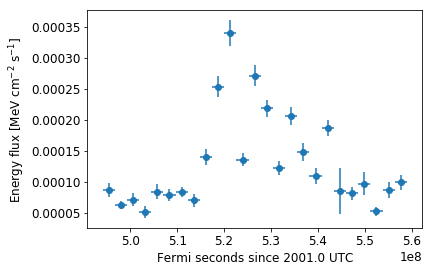

In [98]:
tmean = (lc['tmin'] + lc['tmax'])/2
plt.errorbar(tmean, lc['eflux'],yerr=lc['eflux_err'],xerr=binsize*24*60*60/2, linestyle='None', marker='o')

plt.xlabel('Fermi seconds since 2001.0 UTC')
plt.ylabel('Energy flux [MeV cm$^{-2}$ s$^{-1}$]')

plt.show()

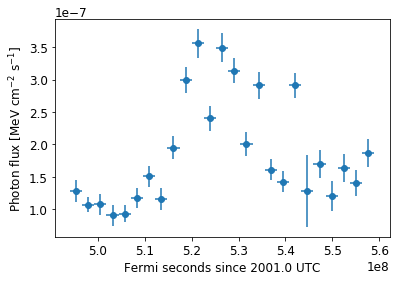

In [99]:
tmean = (lc['tmin'] + lc['tmax'])/2
plt.errorbar(tmean, lc['flux'],yerr=lc['flux_err'],xerr=binsize*24*60*60/2, linestyle='None', marker='o')

plt.xlabel('Fermi seconds since 2001.0 UTC')
plt.ylabel('Photon flux [MeV cm$^{-2}$ s$^{-1}$]')

plt.show()

In [88]:
binsize = 60 #time bin in days

tneutrino = 527806475.400 #Fermi seconds of September 22nd 2017
binsbefore = 8 #number of time bins before the neutrino detection
binsafter = 8 #number of time bins after the neutrino detection

tminLC = tneutrino-(binsbefore*binsize*24*60*60) #start of the first time bin

binsLC = np.array(range(0,binsbefore+binsafter+1))
binsLC = binsLC*(binsize*24*60*60)+tminLC
binsLC=list(binsLC)

binsLC

[486334475.39999998,
 491518475.39999998,
 496702475.39999998,
 501886475.39999998,
 507070475.39999998,
 512254475.39999998,
 517438475.39999998,
 522622475.39999998,
 527806475.39999998,
 532990475.39999998,
 538174475.39999998,
 543358475.39999998,
 548542475.39999998,
 553726475.39999998,
 558910475.39999998,
 564094475.39999998,
 569278475.39999998]

In [89]:
lc = gta.lightcurve('3FGL J0509.4+0541', free_params=['Prefactor'], time_bins=binsLC)

2019-07-31 21:48:28 INFO    GTAnalysis.lightcurve(): Computing Lightcurve for 3FGL J0509.4+0541
2019-07-31 21:48:28 INFO    GTAnalysis._make_lc(): Fitting time range 486334475 491518475
2019-07-31 21:48:51 INFO    GTBinnedAnalysis._create_ltcube(): Generating local LT cube.
/opt/conda/lib/python2.7/site-packages/fermipy/irfs.py:633: RuntimeWarning: invalid value encountered in true_divide
  wrsp /= exps[np.newaxis, :, :]
/opt/conda/lib/python2.7/site-packages/fermipy/irfs.py:264: RuntimeWarning: divide by zero encountered in log
  np.log(self._wts),
2019-07-31 21:49:08 WARNING GTAnalysis._make_lc(): Analysis failed in time range 486334475 491518475
2019-07-31 21:49:08 INFO    GTAnalysis._make_lc(): Fitting time range 491518475 496702475
2019-07-31 21:49:31 INFO    GTBinnedAnalysis._create_ltcube(): Generating local LT cube.
2019-07-31 21:52:18 INFO    GTBinnedAnalysis.write_xml(): Writing /workdir/notebooks/blazar/lightcurve_491518475_496702475/base_00.xml...
2019-07-31 21:52:21 INFO  

2019-07-31 22:32:27 INFO    GTBinnedAnalysis._create_ltcube(): Generating local LT cube.
2019-07-31 22:32:44 WARNING GTAnalysis._make_lc(): Analysis failed in time range 564094475 569278475
2019-07-31 22:32:45 INFO    GTAnalysis.lightcurve(): Finished Lightcurve


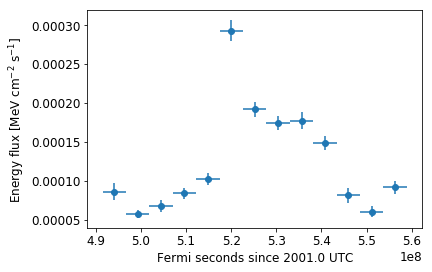

In [90]:
tmean = (lc['tmin'] + lc['tmax'])/2
plt.errorbar(tmean, lc['eflux'],yerr=lc['eflux_err'],xerr=binsize*24*60*60/2, linestyle='None', marker='o')

plt.xlabel('Fermi seconds since 2001.0 UTC')
plt.ylabel('Energy flux [MeV cm$^{-2}$ s$^{-1}$]')

plt.show()

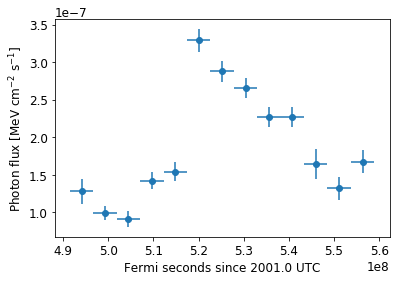

In [91]:
tmean = (lc['tmin'] + lc['tmax'])/2
plt.errorbar(tmean, lc['flux'],yerr=lc['flux_err'],xerr=binsize*24*60*60/2, linestyle='None', marker='o')

plt.xlabel('Fermi seconds since 2001.0 UTC')
plt.ylabel('Photon flux [MeV cm$^{-2}$ s$^{-1}$]')

plt.show()

In [92]:
binsize = 100 #time bin in days

In [93]:
lc = gta.lightcurve('3FGL J0509.4+0541', free_params=['Prefactor'], binsz=(binsize*24*60*60))

2019-07-31 22:32:45 INFO    GTAnalysis.lightcurve(): Computing Lightcurve for 3FGL J0509.4+0541
2019-07-31 22:32:45 INFO    GTAnalysis._make_lc(): Fitting time range 494380804 503020804
2019-07-31 22:33:09 INFO    GTBinnedAnalysis._create_ltcube(): Generating local LT cube.
2019-07-31 22:35:56 INFO    GTBinnedAnalysis.write_xml(): Writing /workdir/notebooks/blazar/lightcurve_494380804_503020804/base_00.xml...
2019-07-31 22:36:01 INFO    GTBinnedAnalysis.write_xml(): Writing /workdir/notebooks/blazar/lightcurve_494380804_503020804/fit_model_final_00.xml...
2019-07-31 22:36:01 INFO    GTAnalysis._make_lc(): Finished time range 494380804 503020804
2019-07-31 22:36:01 INFO    GTAnalysis._make_lc(): Fitting time range 503020804 511660804
2019-07-31 22:36:25 INFO    GTBinnedAnalysis._create_ltcube(): Generating local LT cube.
2019-07-31 22:39:14 INFO    GTBinnedAnalysis.write_xml(): Writing /workdir/notebooks/blazar/lightcurve_503020804_511660804/base_00.xml...
2019-07-31 22:39:18 INFO    GT

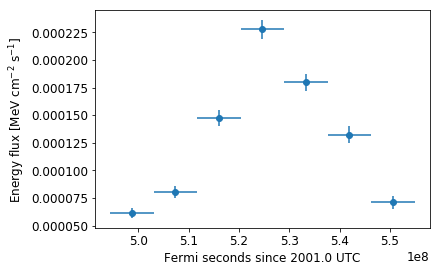

In [94]:
tmean = (lc['tmin'] + lc['tmax'])/2
plt.errorbar(tmean, lc['eflux'],yerr=lc['eflux_err'],xerr=binsize*24*60*60/2, linestyle='None', marker='o')

plt.xlabel('Fermi seconds since 2001.0 UTC')
plt.ylabel('Energy flux [MeV cm$^{-2}$ s$^{-1}$]')

plt.show()

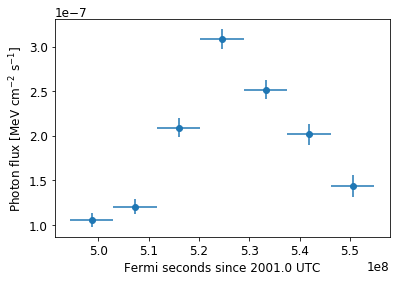

In [95]:
tmean = (lc['tmin'] + lc['tmax'])/2
plt.errorbar(tmean, lc['flux'],yerr=lc['flux_err'],xerr=binsize*24*60*60/2, linestyle='None', marker='o')

plt.xlabel('Fermi seconds since 2001.0 UTC')
plt.ylabel('Photon flux [MeV cm$^{-2}$ s$^{-1}$]')

plt.show()

### Final remarks

There is a lot of other functionality available in the Fermi Tools (like TS Maps, extension tests, source localization) that can be interisting for you. If interested, you can consult [fermipy's documentation](http://fermipy.readthedocs.org) on how to perform them.